# Content-based рекомендации с конструированием новых категориальных переменных и Doc2Vec

## 1. Загрузка данных

In [30]:
import pandas as pd

In [31]:
data = pd.read_csv('/kaggle/input/recsys-cw-data/combined_steam_games.csv')
data.head()

,app_id,name,release_date,required_age,price,dlc_count,short_description,windows,mac,linux,...,discount,developers,publishers,categories,genres,supported_languages,full_audio_languages,tags,screenshots_count,min_package_price
0,20200,Galactic Bowling,"Oct 21, 2008",0,19.99,0,Galactic Bowling is an exaggerated and stylize...,True,False,False,...,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player, Multi-player, Steam Achievement...","Casual, Indie, Sports",English,NaN,"Indie:22, Casual:21, Sports:21, Bowling:6",10,19.99
1,655370,Train Bandit,"Oct 12, 2017",0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,True,True,False,...,0,Rusty Moyher,Wild Rooster,"Single-player, Steam Achievements, Full contro...","Action, Indie","English, French, Italian, German, Spanish - Sp...",NaN,"Indie:109, Action:103, Pixel Graphics:100, 2D:...",5,0.99
2,1732930,Jolt Project,"Nov 17, 2021",0,4.99,0,"Shoot vehicles, blow enemies with a special at...",True,False,False,...,0,Campião Games,Campião Games,Single-player,"Action, Adventure, Indie, Strategy","English, Portuguese - Brazil",NaN,NaN,6,4.99
3,1355720,Henosis™,"Jul 23, 2020",0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,True,True,True,...,0,Odd Critter Games,Odd Critter Games,"Single-player, Full controller support","Adventure, Casual, Indie","English, French, Italian, German, Spanish - Sp...",NaN,"2D Platformer:161, Atmospheric:154, Surreal:15...",7,5.99
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0,0.00,0,Two Weeks in Painland is a story-driven game a...,True,True,False,...,0,Unusual Games,Unusual Games,"Single-player, Steam Achievements","Adventure, Indie","English, Spanish - Spain",NaN,"Indie:42, Adventure:41, Nudity:22, Violent:21,...",24,0.00


In [32]:
# Сопоставления между названиями игр и их id
name_to_id = data['name'].to_dict()
id_to_name = {item[1]: item[0] for item in name_to_id.items()}


# Сопоставления между id игр и их индексами в таблице (пригодится при сравнении векторов)
idx_to_id = data['app_id'].to_dict()
id_to_idx = {item[1]: item[0] for item in idx_to_id.items()}

In [33]:
# оставляем только нужные колонки
data = data[[
    'release_date', 
    'price', 
    'short_description', 
    'windows',
    'mac', 'linux', 'categories', 'genres']]

## 2. Конструируем правила векторизации

__Идея:__
* Категории и жанры - кодируем при помощи OneHotEncoding
* short description - кодируем при помощи модели Doc2Vec
* год выпуска - кодируем в диапазон от 0 до 1
* price - меняем на несколько категориальных признаков (ценовые диапазоны)

### 2.1. Предобработка года выпуска

Из даты выпуска получим год, а затем преобразуем его в нормированную шкалу.

Использование года выпуска как признака может быть объяснено тем, что пользователь может предпочитать старые игры новым, например. 

In [34]:
def extract_year(date: str) -> int:
    if type(date) is not str:
        return 0
    if ',' in date:
        return int(date.split(',')[-1].strip())
    else:
        return int(date.split()[-1].strip())

In [35]:
data['year'] = data['release_date'].apply(extract_year)

data = data.drop(['release_date'], axis=1)

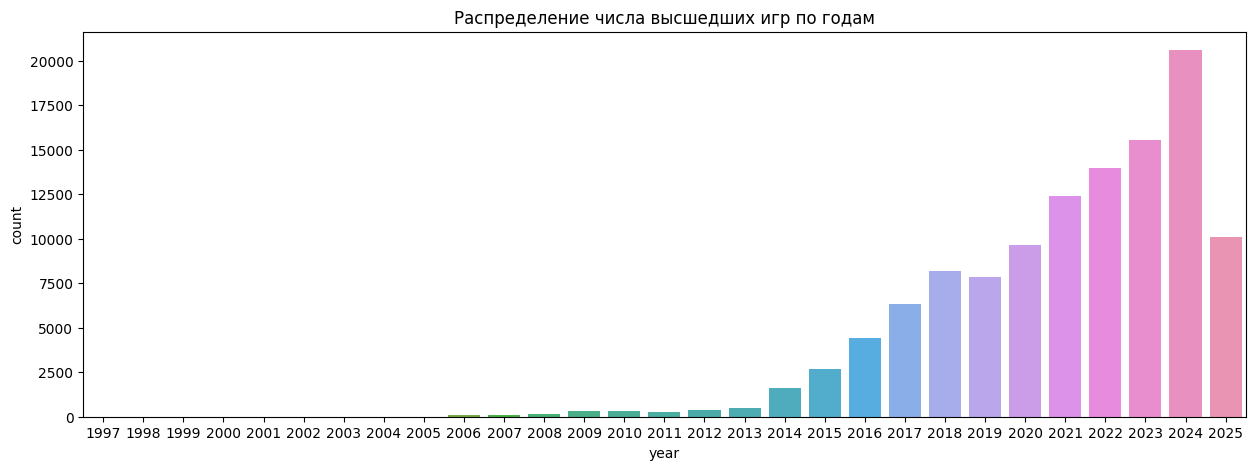

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(15, 5))
plt.title("Распределение числа высшедших игр по годам")
sns.countplot(data=data, x='year');

Преобразуем года к диапазону [0, 1]. 

In [37]:
from sklearn.preprocessing import MinMaxScaler

year_scaler = MinMaxScaler()
data['year'] = year_scaler.fit_transform(data[['year']].values)

### 2.2. Предобработка цены

Цена является важным признаком, поскольку пользователь может предпочитать бесплатные игры или наоборот игры в среднем ценовом диапазоне.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


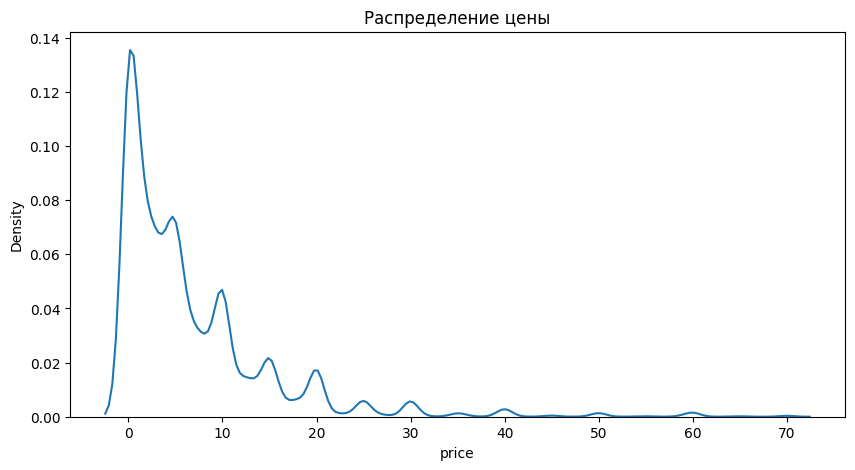

In [38]:
plt.figure(figsize=(10, 5))
plt.title("Распределение цены")
sns.kdeplot(data=data[data['price'] < 70], x='price');

Предобработаем столбец цены по следующему правилу:
- создадим столбец is_free: бесплатная игра или нет.
- создадим столбец '<10': стоимость меньше 10 долларов
- и создадим столбец '>10': стоимость больше 10 долларов

In [39]:
data['is_free'] = data['price'].apply(lambda x: 1 if x == 0.0 else 0)
data['<10'] = data['price'].apply(lambda x: 1 if x < 10 else 0)
data['>=10'] = data['price'].apply(lambda x: 1 if x >= 10 else 0)
data = data.drop(['price'], axis=1)

### 2.3. Предобработка категорий и жанров

In [40]:
def one_hot_encode(df, column_name):
    df_copy = df.copy()
    
    df_copy[column_name] = df_copy[column_name].str.replace(' ', '')
    
    split_categories = df_copy[column_name].str.split(',')
    
    exploded = split_categories.explode()
    
    dummies = pd.get_dummies(exploded, prefix=column_name).astype(float)
    
    result = dummies.groupby(level=0).max()
    
    final_df = pd.concat([df_copy, result], axis=1)
    
    return final_df

In [41]:
data = one_hot_encode(data, 'categories')
data = one_hot_encode(data, 'genres')
data = data.drop(['categories', 'genres'], axis=1)

### 2.4. Windows, Mac, Linux

In [42]:
data['windows'] = data['windows'].astype(float)
data['linux'] = data['linux'].astype(float)
data['mac'] = data['mac'].astype(float)

### 2.5. Модель Doc2Vec для эмбеддингов описаний игр

In [16]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [16]:
texts = data['short_description']

tagged_data = [TaggedDocument(words=word_tokenize(doc.lower() if type(doc) is str else ''),
                              tags=[str(i)]) for i,
               doc in enumerate(texts)]

In [17]:
# Обучаем модель
model = Doc2Vec(vector_size=100,
                min_count=2, epochs=50, workers=8)

model.build_vocab(tagged_data)
model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)

In [18]:
model.save("doc2vec.model")

In [45]:
model = Doc2Vec.load("/kaggle/input/doc2vec/other/default/2/doc2vec.model")

### 2.6. Понижение размерности полученных категориальных векторов

Этот шаг необходим для того чтобы снизить влияние полученных категориальных признаков на значения косинусной близости. Из-за One-hot-encoding возникло много булевых признаков, что сильно смещает значения косинусной близости к единице. 

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data = data.drop(['short_description'], axis=1)

cat = StandardScaler().fit_transform(data.values)
pca = PCA(n_components=28)
cat = pca.fit_transform(cat)

### 2.7. Объединяем полученные признаки в единые векторы

In [47]:
import numpy as np

vectors = np.concatenate([cat, model.dv.vectors], axis=1)
vectors.shape

(115494, 128)

### 2.8. Прототип рекомендательной системы

In [ ]:
!pip install faiss-cpu

In [58]:
import faiss

index = faiss.IndexFlatIP(vectors.shape[1])
vectors = vectors.astype(np.float32)
faiss.normalize_L2(vectors)
index.add(vectors)

In [59]:
index.search(np.array([vectors[0]]), 10)

(array([[1.        , 0.6627437 , 0.6467781 , 0.60904574, 0.60864526,
         0.60153484, 0.6010351 , 0.59501475, 0.59095925, 0.5907054 ]],
       dtype=float32),
 array([[    0,  4835, 48538, 30063,  9542, 24440, 80640, 45090, 43362,
         60746]]))

## 3. Формируем итоговую рекомендательную систему

In [60]:
import numpy as np
from abc import ABCMeta, abstractmethod
    

class SteamDatasetVectorizer(metaclass=ABCMeta):
    @abstractmethod
    def vectorize_dataset(self, dataset: pd.DataFrame) -> np.ndarray[np.ndarray]:
        """
        Отображает каждую игру из датасета в численный вектор
        """
        pass 

In [61]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


class Doc2VecSteamDatasetVectorizer(SteamDatasetVectorizer):
    def __init__(self, doc2vec_checkpoint: str):
        super().__init__()
        self.doc2vec = Doc2Vec.load(doc2vec_checkpoint)

    def _extract_year(self, date: str) -> int:
        if type(date) is not str:
            return 0
        if ',' in date:
            return int(date.split(',')[-1].strip())
        else:
            return int(date.split()[-1].strip())

    def _one_hot_encode(self, df, column_name):
        df_copy = df.copy()
        
        df_copy[column_name] = df_copy[column_name].str.replace(' ', '')
        
        split_categories = df_copy[column_name].str.split(',')
        
        exploded = split_categories.explode()
        
        dummies = pd.get_dummies(exploded, prefix=column_name).astype(float)
        
        result = dummies.groupby(level=0).max()
        
        final_df = pd.concat([df_copy, result], axis=1)
        
        return final_df
        
    def vectorize_dataset(self, dataset: pd.DataFrame) -> np.ndarray[np.ndarray]:
        data = dataset.copy()
        data = data[[
            'release_date', 
            'price', 
            'short_description', 
            'windows',
            'mac', 'linux', 'categories', 'genres']]
        
        # 1. предобработка года
        data['year'] = data['release_date'].apply(self._extract_year)
        data = data.drop(['release_date'], axis=1)

        # 2. предобработка цены
        data['is_free'] = data['price'].apply(lambda x: 1 if x == 0.0 else 0)
        data['<10'] = data['price'].apply(lambda x: 1 if x < 10 else 0)
        data['>=10'] = data['price'].apply(lambda x: 1 if x >= 10 else 0)
        data = data.drop(['price'], axis=1)
        
        # 3. предобработка категорий и жанров
        data = self._one_hot_encode(data, 'categories')
        data = self._one_hot_encode(data, 'genres')
        data = data.drop(['categories', 'genres'], axis=1)
        
        # 4. предобработка столбцов с ОС
        data['windows'] = data['windows'].astype(float)
        data['linux'] = data['linux'].astype(float)
        data['mac'] = data['mac'].astype(float)

        # 5. Понижение размерности на категориальных признаках
        data = data.drop(['short_description'], axis=1)
        cat = StandardScaler().fit_transform(data.values)
        pca = PCA(n_components=28)
        cat = pca.fit_transform(cat)
        
        # 5. эмбеддинги описаний
        text_embeddings = self.doc2vec.dv.vectors
        
        # 6. формирование итоговых векторных представлений
        vectors = np.concatenate([cat, text_embeddings], axis=1)
        
        return vectors

In [ ]:
import os
import json
import faiss
from dataclasses import dataclass 


@dataclass
class ContentBasedRecommendation:
    original: int # исходная игра
    recommendation: int # похожая на нее
    similarity: float # коэффициент похожести


class InvalidVectorizerType(ValueError):
    pass 
    
class InvalidSteamDataset(ValueError):
    pass

class InvalidPath(ValueError):
    pass

class NotFitted(ValueError):
    pass 

class GameNotFound(ValueError):
    pass 



class SteamContentBasedRecSys:
    def __init__(self):
        self.required_columns = [
            'app_id', 'name', 'release_date', 'required_age', 
            'price', 'short_description', 'windows', 'mac', 
            'linux', 'developers', 'publishers', 'categories', 
            'genres', 'supported_languages', 'tags', 'min_package_price'
        ]
        self.fitted = False

    def _validate_dataset(self, dataset: pd.DataFrame) -> bool:
        """
        Если датасет содержит все необходимые столбцы -> True
        Иначе бросается исключение InvalidSteamDataset
        """
        for col in self.required_columns:
            if col not in dataset:
                raise InvalidSteamDataset(f"Missing column: {col}")
        return True
        
    def fit(self, vectorizer: SteamDatasetVectorizer, dataset: pd.DataFrame):
        """Обучение рекомендательной системы"""
        # валидация входных данных
        self._validate_dataset(dataset)
        if not isinstance(vectorizer, SteamDatasetVectorizer):
            raise InvalidVectorizerType("vectorizer must be subclass of SteamDatasetVectorizer class")
        
        # Сопоставления между id игр и их индексами в таблице (пригодится при сравнении векторов)
        self.idx_to_id = data['app_id'].to_dict()
        self.id_to_idx = {item[1]: item[0] for item in self.idx_to_id.items()}

        # получаем векторы
        vectors = vectorizer.vectorize_dataset(dataset).astype(np.float32)
        faiss.normalize_L2(vectors)
        
        assert vectors.shape[0] == dataset.shape[0], "Количество игр должно совпадать!"

        
        self.index = faiss.IndexFlatIP(vectors.shape[1])  # индекс для расчета косинусной близости
        self.index.add(vectors)
        self.fitted = True
        return self

    def save(self, index_path: str = './steam.index', idx2id_path: str = 'idx2id.json') -> None:
        """
        * index_path: str - путь до .index файла, куда будет сохранена векторная база данных
        * idx2id_path: str - путь до .json файла, куда будет сохранено соответствие между id игр и их индексами в БД
        """
        if not index_path.endswith('.index'):
            raise InvalidPath(f"Index file must have a .index format")
            
        if not self.fitted:
            raise NotFitted("Fit the system first via .fit() method")
            
        if not idx2id_path.endswith('.json'):
            raise InvalidPath(f"idx2id path must have a .json format")
            
        faiss.write_index(self.index, index_path)
        with open(idx2id_path, 'w') as idx2id_file:
            json.dump(self.idx_to_id, idx2id_file)

    def load(self, index_path: str, idx2id_path: str):
        if not index_path.endswith('.index'):
            raise InvalidPath(f"Index file must have a .index format")
            
        if not idx2id_path.endswith('.json'):
            raise InvalidPath(f"idx2id path must have a .json format")

        if not os.path.exists(index_path):
            raise InvalidPath(f"File: {index_path} does not exists")

        if not os.path.exists(idx2id_path):
            raise InvalidPath(f"File: {idx2id_path} does not exists")

        self.index = faiss.read_index(index_path)
        with open(idx2id_path, 'r') as idx2id_file:
            loaded_idx_to_id: dict = json.load(idx2id_file)

        self.idx_to_id = {int(k): int(v) for k, v in loaded_idx_to_id.items()}
        self.id_to_idx = {int(v): int(k) for k, v in loaded_idx_to_id.items()}
        self.fitted = True
        return self

    
    def _get_game_vector(self, game_id: int) -> np.ndarray:
        if game_id not in self.id_to_idx:
            raise GameNotFound(f"Game with id={game_id} does not exists")
        game_idx = self.id_to_idx[game_id]
        
        return self.index.reconstruct(game_idx)

    
    def _find_similar_games(self, games: list[int], k: int = 10) -> tuple[np.ndarray[np.ndarray], np.ndarray[np.ndarray]]:
        """Поиск игр похожих на заданные"""
        vectors = []
        for game in games:
            vectors.append(self._get_game_vector(game))
        vectors = np.array(vectors)
    
        distances, indexes = self.index.search(vectors, k+1)  # +1 чтобы исключить исходные игры
        return distances[:, 1:], indexes[:, 1:]


    def recommend(self, liked: list[int], M: int) -> list[ContentBasedRecommendation]:
        """Формирование content-based рекомендации"""
        distances, indexes = self._find_similar_games(liked, M)
        merged = []
        for i in range(len(liked)):
            liked_i = liked[i]
            rec_i = indexes[i]
            dists_i = distances[i]
            for j in range(M):
                merged.append((liked_i, rec_i[j], dists_i[j]))
                
        merged = sorted(merged, key=lambda x: x[2], reverse=True)
    
        answer = []
        liked = set(liked)
        for x in merged:
            if x[1] not in liked:
                answer.append(ContentBasedRecommendation(original=x[0], recommendation=x[1], similarity=x[2]))
                if len(answer) == M:
                    break
        return answer
    

In [85]:
data = pd.read_csv('/kaggle/input/recsys-cw-data/combined_steam_games.csv')

vectorizer = Doc2VecSteamDatasetVectorizer("/kaggle/input/doc2vec/other/default/2/doc2vec.model")

recsys = SteamContentBasedRecSys().fit(vectorizer, data)

In [86]:
recsys.save()

In [87]:
recsys.load('/kaggle/working/steam.index', '/kaggle/working/idx2id.json')

In [77]:
recsys.index.search(np.array([recsys.index.reconstruct(0)]), 2)

(array([[1.       , 0.6627438]], dtype=float32), array([[   0, 4835]]))

In [94]:
liked = [
    20200,
    1139950,
    1355720
]

M = 30

recsys.recommend(liked, M)

[ContentBasedRecommendation(original=1355720, recommendation=33878, similarity=0.69596684),
 ContentBasedRecommendation(original=1355720, recommendation=64044, similarity=0.6937763),
 ContentBasedRecommendation(original=1355720, recommendation=41490, similarity=0.6864152),
 ContentBasedRecommendation(original=1355720, recommendation=70100, similarity=0.68421835),
 ContentBasedRecommendation(original=1355720, recommendation=61711, similarity=0.6839969),
 ContentBasedRecommendation(original=1355720, recommendation=40770, similarity=0.6764049),
 ContentBasedRecommendation(original=1355720, recommendation=25921, similarity=0.6665389),
 ContentBasedRecommendation(original=1355720, recommendation=5908, similarity=0.6664127),
 ContentBasedRecommendation(original=1355720, recommendation=26623, similarity=0.66436756),
 ContentBasedRecommendation(original=1355720, recommendation=53595, similarity=0.6638105),
 ContentBasedRecommendation(original=1355720, recommendation=5146, similarity=0.66336834